In [1]:
import time
import math

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as color_maps
from pathlib import Path
import seaborn as sns
import tqdm

from simple_ml import generate_dataset, plot_functions, compute_loss_surface
from simple_ml.shallow_network import ShallowNetwork

pd.set_option('max_colwidth', 500)
sns.set_theme()

%load_ext autoreload
%autoreload 2

## Define and visualize the data-points.

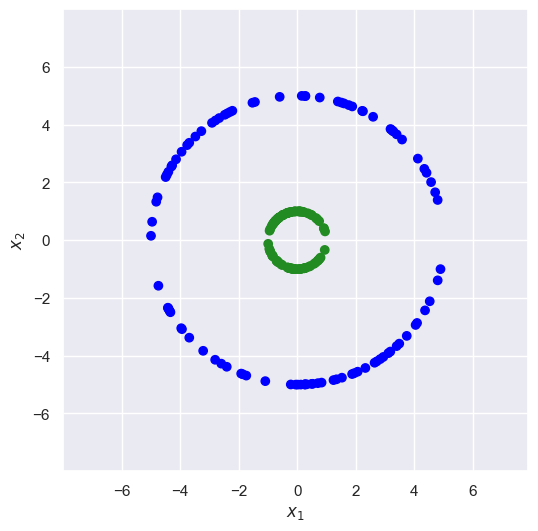

In [9]:
# There are other dataset options including lines and a full-circle.
df = generate_dataset.generate_circle_dataset(inner_radius=1, outer_radius=5, num_data_points_per_class=100)

plot_functions.create_dataset_plot(df)

### Model training parameters

In [14]:
num_steps = 50_000
early_stopping_no_improvement_num_steps = 5_000
early_stopping_min_improvement = 1e-5
num_updates_to_print = 10

num_hidden_units = 3
model = ShallowNetwork(num_hidden_units)

loss_fn = torch.nn.BCELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters())

### Train the model.

In [15]:
start_time = time.time()

best_loss, best_step = float('inf'), -1

for step in range(num_steps):
        
    X = torch.Tensor(df[['x1', 'x2']].values)
    Y = torch.Tensor(df['y'].values)

    predictions = model(X)
    
    per_element_loss = loss_fn(predictions, Y)
    total_loss = per_element_loss.sum()

    # Take the partial-derivative of the total_loss w.r.t. each 
    # model-parameter (i.e. torch.nn.Parameter object). And store that 
    # partial-derivative in each Parameter object.
    total_loss.backward()
    # Update each parameter, leveraging it's stored gradient.
    optimizer.step()
    # Clear the stored gradient to prevent accumulation.
    optimizer.zero_grad()
    

    if step % (int(num_steps / num_updates_to_print)) == 0:
        print(
            f"Training step: {step:,}. Total loss: {total_loss.item():.5f}. "
            f"Total time elapsed: {time.time() - start_time:.2f}s."
        )
    
    if total_loss < (best_loss - early_stopping_min_improvement):
        best_loss = total_loss
        best_step = step
    
    if (step - best_step) > early_stopping_no_improvement_num_steps:
        print(
            f"Early stopping at step: {step}. The loss hasn't improved in the past {early_stopping_no_improvement_num_steps:,} "
            f"training steps. The best loss achieved was {best_loss.item():.5f} at step: {best_step:,}. "
            f"The current step's loss is {total_loss.item():.5f}."
        )
        break

Training step: 0. Total loss: 1.54514. Total time elapsed: 0.00s.
Training step: 5,000. Total loss: 0.21536. Total time elapsed: 2.04s.
Training step: 10,000. Total loss: 0.21351. Total time elapsed: 4.04s.
Early stopping at step: 14743. The loss hasn't improved in the past 5,000 training steps. The best loss achieved was 0.21351 at step: 9,742. The current step's loss is 0.21351.


### Hidden-unit activation boundaries

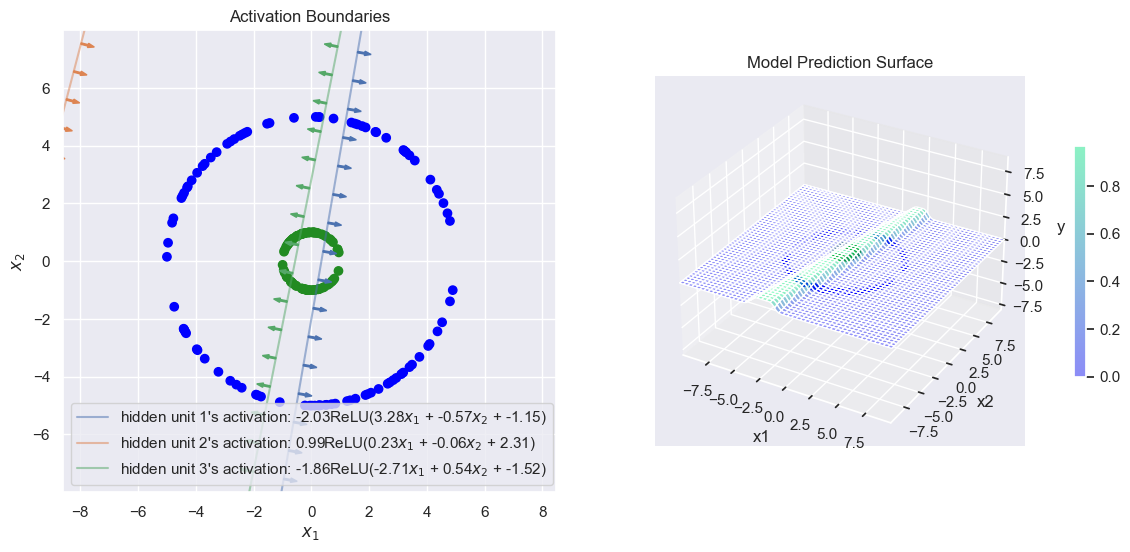

In [31]:
plot_functions.create_model_performance_plot(model, df)

### Model surface

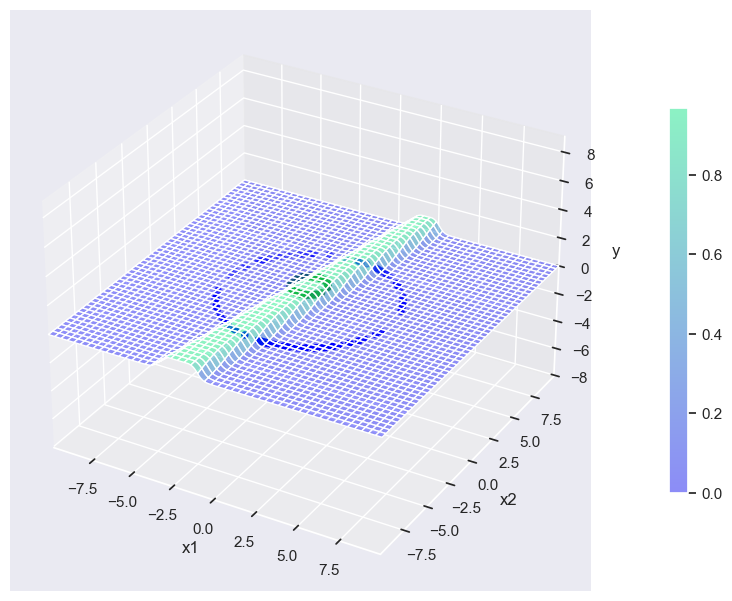

In [17]:
plot_functions.create_model_performance_plot_3d(model, df)

### Loss Surface

In [ ]:
parameters_and_losses = compute_loss_surface.compute_all_possible_models_and_losses(df)
hidden_slope1s, output_slopes, losses = [np.array(t) for t in zip(*parameters_and_losses)]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

num_data_points = len(parameters_and_losses)
sqrt_num_data_points = int(np.sqrt(num_data_points))

# I don't know why, but the x, y and z arguments to this function are supposed to be 2-D arrays.
surface = ax.plot_surface(
    hidden_slope1s.reshape((sqrt_num_data_points, sqrt_num_data_points)),
    output_slopes.reshape((sqrt_num_data_points, sqrt_num_data_points)),
    losses.reshape((sqrt_num_data_points, sqrt_num_data_points)),
    cmap=color_maps.winter,
    alpha=0.4
)

fig.colorbar(surface, shrink=0.5, pad=0.1)
ax.set(xlabel="hidden_slope1", ylabel="output_slope", zlabel="loss")
ax.set_xlim([hidden_slope1s.min(), hidden_slope1s.max()])
_ = ax.set_ylim([output_slopes.min(), output_slopes.max()])

In [ ]:
best_hidden_slope1, best_output_slope, best_loss = parameters_and_losses[losses.argmin()]
print(f"The optimal parameters discovered via exhaustive-search are hidden_slope1: {best_hidden_slope1:.2f}, output_slope: {best_output_slope:.2f} with a loss of: {best_loss:.2f}.")

In [ ]:
manual_model = ShallowNetwork(num_hidden_units=1)

# Set the hidden-layer params.
manual_model.hidden_units[0]._set_params(
    slope1=best_hidden_slope1, 
    slope2=compute_loss_surface.hidden_slope_2_value, 
    offset=compute_loss_surface.hidden_offset
)
# Set the output-layer params.
manual_model._set_params(
    hidden_unit_scales=[best_output_slope], 
    offset=compute_loss_surface.output_offset
)

# plot_functions.create_model_performance_plot_3d(manual_model, df)
plot_functions.create_model_performance_plot_2d(manual_model, df)

In [ ]:
import imageio

image_filepaths = [image_path for image_path in plot_images_path.glob("*.png")]
# Sort by last-modified time, so the images are in the same order they were made during training.
image_filepaths.sort(key=lambda path: path.lstat().st_mtime)

images = []
for image_filepath in image_filepaths:
    
    image = iio.imread(image_filepath)
    images.append(image)

iio.imwrite('training.gif', images)